In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from windtools.plotting import plot_profile, plot_timehistory_at_height
from erftools.postprocessing import AveragedProfiles, Plotfile

# DNS of Turbulent Flow through a Plane Channel

We consider the Reynolds number $Re_\tau = 395$ case (based on friction velocity $u_\tau$ and the channel half height $\delta$) from Moser, Kim, and Mansour
1999, _Phys. Fluids_.

Reference data were download from [this archive](https://turbulence.oden.utexas.edu/MKM_1999.html).

The cosine grid stretching in the wall-normal direction used in the original work results in extreme grid stretching near walls, so we instead use a tanh function as in Abe et al. 2001, _J. Fluids Engr_.
The tanh stretching parameter was tuned to achieve a specified grid spacing at the center of the channel. For relatively coarse grid spacing, we are able to recover profiles of $\langle u'u' \rangle$ and $\langle u'w' \rangle$ but underpredict $\langle w'w' \rangle$. A surface grid spacing of $y^+ \approx 0.1$ was necessary to match the vertical velocity variance in the buffer layer and log layer.

In [2]:
Re_tau = 395.

cases = {
    'uniform (y+=1)': 'uniform_yplus_1',
    'tanh (y+ ~ 0.4 to 9.6)': 'tanh_yplus_0.4_to_9.6',
    'tanh (y+ ~ 0.14 to 6.5)': 'tanh_yplus_0.1_to_6.5',
}

Tave = 10.0 # nondim time period for average

In [3]:
# plotting setup
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['font.family'] = 'serif'

mkm_style = dict(color='k', linewidth=2.5, linestyle='--')

## flow visualization

(0.0, 6.2831853072, 0.0, 2.0)

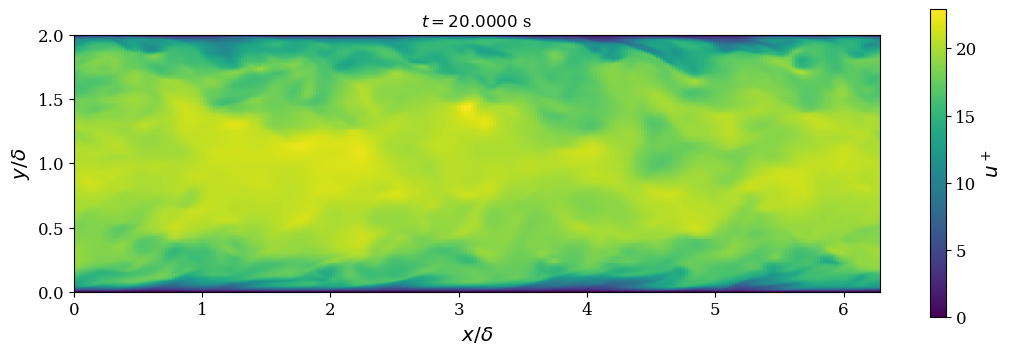

In [4]:
pf = Plotfile('tanh_yplus_0.1_to_6.5/plt1000000')
prob_extent = pf.attrs['domain_width']
nx,ny,nz = pf.dims

ds = pf.slice(1, prob_extent[1]/2, fields='x_velocity')
u = ds['x_velocity'].squeeze()

x1 = np.linspace(0, prob_extent[0], nx+1)
if pf.stretched_dz:
    z1 = pf.terrain_z_levels
else:
    z1 = np.linspace(0, prob_extent[2], nz+1)
xx,zz = np.meshgrid(x1, z1, indexing='ij')

fig,ax = plt.subplots(figsize=(13,4))
cmsh = ax.pcolormesh(xx, zz, u, vmin=0)
cbar = fig.colorbar(cmsh)
cbar.set_label('$u^+$')
ax.set_xlabel('$x/\\delta$')
ax.set_ylabel('$y/\\delta$')
ax.set_title(f'$t = {pf.time:.4f}$ s')
ax.axis('scaled')

## load data for comparison

In [5]:
def read_ref_file(fpath,Nheader=23):
    with open(fpath,'r') as f:
        for _ in range(Nheader):
            f.readline()
        columns = f.readline().split()[1:]
        f.readline()
        print('Read',columns)
        df = pd.read_csv(f,names=columns,sep='\s+')
    #df['y'] *= h
    df = df.set_index('y')
    return df
    
means = read_ref_file('ref/chan395/profiles/chan395.means')
reystress = read_ref_file('ref/chan395/profiles/chan395.reystress')

Read ['y', 'y+', 'Umean', 'dUmean/dy', 'Wmean', 'dWmean/dy', 'Pmean']
Read ['y', 'y+', 'R_uu', 'R_vv', 'R_ww', 'R_uv', 'R_uw', 'R_vw']


In [6]:
sims = {}

for case,simdir in cases.items():
    ncfile = f'{simdir}/postproc.nc'
    if os.path.isfile(ncfile):
        print('Loading postprocessed data from',ncfile)
        ds = xr.open_dataset(ncfile)
        ds = ds.rename({'dudz(stag)': 'du/dz(stag)'})
        sims[case] = ds
        continue
    
    pavg = AveragedProfiles(f'{simdir}/mean_profiles.dat',
                            f'{simdir}/flux_profiles.dat')
    pavg.calc_grad('u', two_point=True) # from cell centers to face centers\
    ds = pavg.ds

    # non-dimensional coordinates
    zplus = ds.coords['z'] * Re_tau
    zsplus = ds.coords['zstag'] * Re_tau
    ds = ds.assign_coords(z=zplus, zstag=zsplus)

    # time averaging
    avgperiod = slice(ds.t[-1]-Tave, None)
    ds = ds.sel(t=avgperiod).mean('t')

    sims[case] = ds
    
    # workaround for netcdf4
    ds = ds.rename({'du/dz(stag)': 'dudz(stag)'}) 
    ds.to_netcdf(ncfile)

Loading postprocessed data from uniform_yplus_1/postproc.nc
Loading postprocessed data from tanh_yplus_0.4_to_9.6/postproc.nc
Loading postprocessed data from tanh_yplus_0.1_to_6.5/postproc.nc


## plots

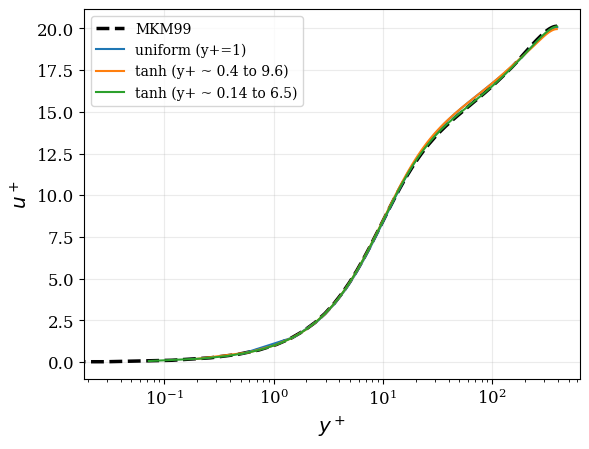

In [7]:
fig,ax = plt.subplots()
ax.semilogx(means['y+'], means['Umean'], label='MKM99', **mkm_style)

for case,ds in sims.items():
    umean = ds['u'].sel(z=slice(0,Re_tau))
    ax.semilogx(umean.z, umean, label=case)
ax.legend(loc='best')
ax.set_xlabel('$y^+$')
ax.set_ylabel('$u^+$')
ax.grid(alpha=0.25)

Text(0, 0.5, '$y^+$')

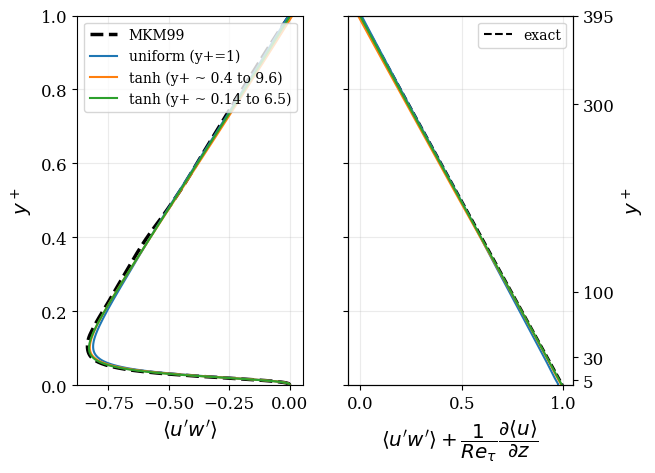

In [8]:
fig,axs = plt.subplots(ncols=2,sharey=True)
axs[0].plot(reystress['R_uv'], reystress.index, label='MKM99', **mkm_style)
axs[1].plot([0,1],[1,0],c='k',ls='--',label='exact')

for case,ds in sims.items():
    uwmean = ds["u'w'"].sel(zstag=slice(0,Re_tau))
    axs[0].plot(uwmean, uwmean.zstag/Re_tau, label=case)

    shear = 1/Re_tau * ds["du/dz(stag)"]
    totstress = -uwmean + shear
    axs[1].plot(totstress, totstress.zstag/Re_tau)
    
axs[0].set_ylabel('$y^+$')
axs[0].set_xlabel("$\\langle u'w' \\rangle$")
axs[1].set_xlabel(r"$\langle u'w' \rangle + \dfrac{1}{Re_\tau} \dfrac{\partial \langle u \rangle}{\partial z}$")
for ax in axs:
    ax.grid(alpha=0.25)
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper right')
axs[0].set_ylim((0,1))

twin = axs[-1].twinx()
twin.set_yticks([5,30,100,300,Re_tau])
twin.set_ylabel('$y^+$')

Text(0, 0.5, '$y^+$')

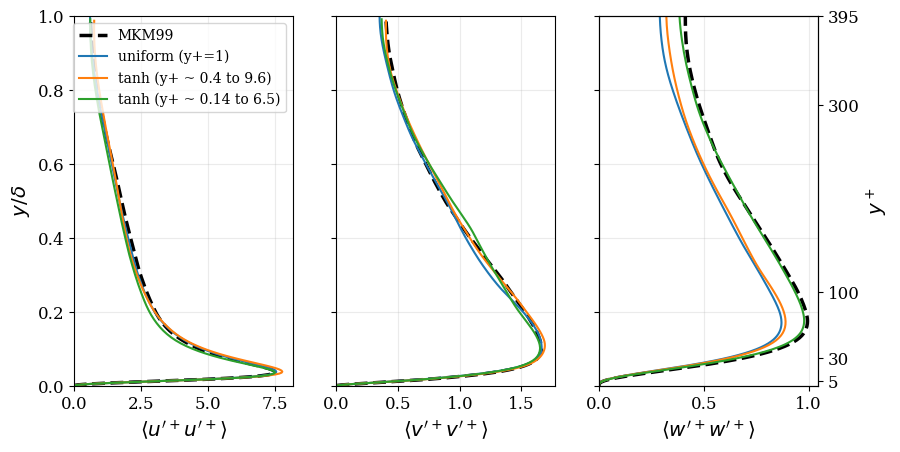

In [9]:
fig,axs = plt.subplots(ncols=3,sharey=True,figsize=(9.6,4.8))
axs[0].plot(reystress['R_uu'], reystress.index, label='MKM99', **mkm_style)
axs[1].plot(reystress['R_ww'], reystress.index, label='MKM99', **mkm_style)
axs[2].plot(reystress['R_vv'], reystress.index, label='MKM99', **mkm_style)

for case,ds in sims.items():
    uumean = ds["u'u'"].sel(z=slice(0,Re_tau))
    vvmean = ds["v'v'"].sel(z=slice(0,Re_tau))
    wwmean = ds["w'w'"].sel(zstag=slice(0,Re_tau))
    axs[0].plot(uumean, uumean.z/Re_tau, label=case) 
    axs[1].plot(vvmean, vvmean.z/Re_tau, label=case)
    axs[2].plot(wwmean, wwmean.zstag/Re_tau, label=case)
    
axs[0].set_ylabel('$y/\\delta$')
axs[0].set_xlabel(r"$\langle u'^+ u'^+ \rangle$")
axs[1].set_xlabel(r"$\langle v'^+ v'^+ \rangle$")
axs[2].set_xlabel(r"$\langle w'^+ w'^+ \rangle$")
for ax in axs:
    ax.grid(alpha=0.25)
    ax.set_xlim((0,None))
axs[0].legend(loc='upper right')
axs[0].set_ylim((0,1))

twin = axs[-1].twinx()
twin.set_yticks([5,30,100,300,Re_tau])
twin.set_ylabel('$y^+$')